# Inferential Statistics in Python
## Data Science Tools I
### Terron Ishihara and Don Dalton | University of Denver


---

This notebook covers various hypothesis tests, including t-tests, ANOVA, and regression analysis. z-tests are not covered here, but a Python implementation for z-tests can be found in the `statsmodels` package: https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ztest.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

# One Sample Test

Glassdoor claims that the average base salary of a professor is $98,500. We would like to use a sample to test if this is accurate.

![](https://drive.google.com/uc?id=19WZ_D8j_zDY1R53P2Vx0GFms18xtslW3)

The data we're using here is actually from 2008-2009, so this is not a realistic comparison. For the sake of learning, let's just assume that the data is current.

Link to data details: https://vincentarelbundock.github.io/Rdatasets/doc/carData/Salaries.html

In [2]:
url = "https://vincentarelbundock.github.io/Rdatasets/csv/carData/Salaries.csv"
salary_data = pd.read_csv(url)
salary_data.drop("Unnamed: 0", axis=1, inplace=True)
salary_data.rename({"yrs.since.phd": "years_since_phd", "yrs.service": "years_of_service"}, axis=1, inplace=True)
salary_data.discipline = salary_data.discipline.replace({'A': 'theory', 'B': 'applied'})
salary_data.head()

,rank,discipline,years_since_phd,years_of_service,sex,salary
0,Prof,applied,19,18,Male,139750
1,Prof,applied,20,16,Male,173200
2,AsstProf,applied,4,3,Male,79750
3,Prof,applied,45,39,Male,115000
4,Prof,applied,40,41,Male,141500


We can get an idea of our data's distribution by observing its statistical properties.

In [3]:
salary_data.describe()

,years_since_phd,years_of_service,salary
count,397.000000,397.000000,397.000000
mean,22.314861,17.614610,113706.458438
std,12.887003,13.006024,30289.038695
min,1.000000,0.000000,57800.000000
25%,12.000000,7.000000,91000.000000
50%,21.000000,16.000000,107300.000000
75%,32.000000,27.000000,134185.000000
max,56.000000,60.000000,231545.000000


## Preliminary Analysis

We ultimately want to apply a hypothesis test. This test comes with a set of assumptions:

* The population is normally distributed
  * If it is not, we can check if this is due to outliers that we could ignore.
  * Either way, we can also ensure that the sample size is sufficiently large.
* Observations are independent of each other
* Data is quantitative (an obvious requirement)

The third assumption is trivial and the second is generally just assumed to be met. Observations being independent of one another is a factor of how the sample has been taken from the population.

The first assumption we can easily check with a histogram, boxplot, and/or descriptive statistics (mean, median, mode, etc.). 

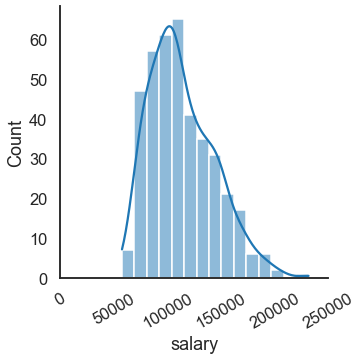

In [4]:
plot = sns.displot(data=salary_data.salary, kde=True) # kde is an estimation of the data's distribution
plot.set_xticklabels(rotation=30); # make ticks readable

<AxesSubplot:>

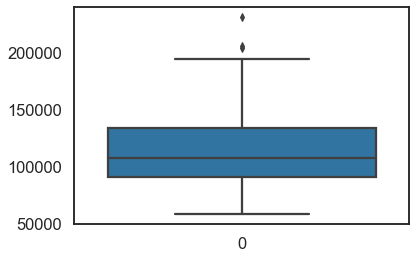

In [5]:
sns.boxplot(data=salary_data.salary)

Skewness is a single value you can use to test the normality of a distribution. If the skew is between -1 and 1, the distribution of the data is close to normal.

In [6]:
salary_data.salary.skew()

0.71456845319916

We can confidently deduce from the above observations that this data is relatively normal. If it were not, we would have to consider the size of our sample as well. This sample happens to be quite large, so regardless we can continue on to the hypothesis test.

In [7]:
salary_data.shape[0] # How many rows (observations) are in the sample?

397

## One Sample t-test

Remember the the null hypothesis asserts that nothing special is happening. $H_0$ would therefore state that Glassdoor's average is correct and our sample is not a rare outcome.
$$
H_0: \mu = 98,500
$$
$$
H_1: \mu \ne 98,500
$$

Actually executing the t-test is more tedious by hand, so fortunately there are libraries that can do all of these for us. We import the test from SciPy's `stats` package and observe the resulting p-value.



In [8]:
from scipy import stats

test_stat, pvalue = stats.ttest_1samp(salary_data.salary, popmean=98500)

The resulting p-value is vanishingly small (21 decimal places out). Although we would probably state an $\alpha$ of 0.05, regardless of our choice of $\alpha$ we can confidently **reject** the null hypothesis.

A formal report of the findings might look something like this:

> A one-sample hypothesis t-test was conducted to examine whether the mean salary of faculty is statistically significantly different from the average faculy salary on glassdoor.com ($98,500 per year). The findings of the test revealed with a p-value of 3.74e-21 and alpha of 0.05 that there is a significant difference between the average salary of sampled faculty and the reported average. 

# Two Sample Test

As an example of a two-sample test, let's compare the salaries of male and female professors. Our research question is whether or not there is a significant difference in the mean salary of male professors vs the mean salary of female professors.

In [9]:
male_salary = salary_data.salary[salary_data.sex == 'Male']
print(male_salary.shape)
male_salary.head()

(358,)


0    139750
1    173200
2     79750
3    115000
4    141500
Name: salary, dtype: int64

In [10]:
female_salary = salary_data.salary[salary_data.sex == 'Female']
print(female_salary.shape)
female_salary.head()

(39,)


9     129000
19    137000
24     74830
34     80225
35     77000
Name: salary, dtype: int64

## Preliminary Analysis

We can use the groupby method to observe the means of each subcategory.

In [11]:
salary_data[['salary', 'sex']].groupby('sex').mean()

,salary
sex,
Female,101002.410256
Male,115090.418994


As before, we check for normality of the sample distribution.

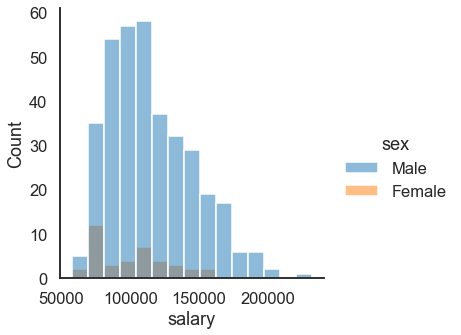

In [12]:
sns.displot(data=salary_data, x='salary', hue='sex')

0.7208921489818444


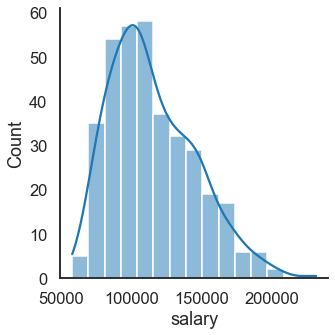

In [13]:
sns.displot(data=male_salary, kde=True)
print(male_salary.skew())

0.4580322018771293


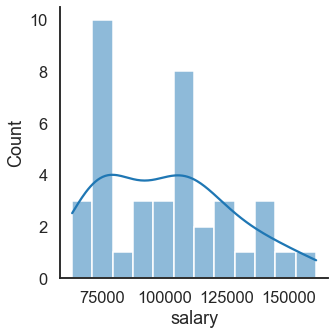

In [14]:
sns.displot(data=female_salary, bins=12, kde=True) # Increased num bins to see more detail
print(female_salary.skew())

<AxesSubplot:title={'center':'salary'}, xlabel='[sex]'>

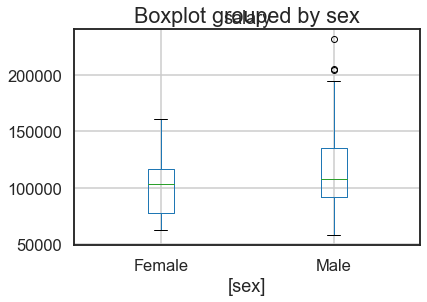

In [15]:
salary_data[['salary', 'sex']].boxplot(by='sex')

In addition to normality, for a two-sample test, we must also ensure that the variance between the two samples is roughly equal. There are a few tests that will check for significant differences in variance, such as Bartlett's test and the F-test. We will use Levene's test which seems to be reported as the most robust. 

This is its own sort of hypothesis test, with a returned test statistic and p-value. If the null hypothesis is not rejected (i.e. retained), the variance is roughly equal between the two samples and we can proceed to performing the t-test.

In [16]:
test_stat, p_value = stats.levene(male_salary, female_salary)
alpha = 0.05

if p_value > alpha:
  print("Retain H0 - variance is roughly equal")
else:
  print("Reject H0 - variance is not equal")

print(f"alpha: {alpha}")
print(f"p-value: {p_value}")  # if p-value is not less than 0.05 then we cannot reject null hypothesis that variance is the same
print(f"test stat: {test_stat}")

Retain H0 - variance is roughly equal
alpha: 0.05
p-value: 0.35993255760111553
test stat: 0.8400820216384142


https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality.  If p-value is not less than 0.05 then we cannot reject null hypothesis that variance is the same.

P-Values clearly explained: https://www.youtube.com/watch?v=5Z9OIYA8He8

## Two Sample t-test

We can perform the t-test much like before but with two independent samples. Just as `ttest_1samp` used a null hypothesis that the population mean is a given value, here `ttest_ind` uses a null hypothesis that the independent samples have the same mean.

In [17]:
stats.ttest_ind(male_salary, female_salary, equal_var=True)

Ttest_indResult(statistic=2.781674064262432, pvalue=0.005667106519338681)

For an $\alpha$ of 0.05 and resulting p-value of 0.0057, we reject the null hypothesis and conclude that the average salaries of male and female professors significantly differ. Very small p-value means to reject null hypothesis.

# ANOVA

Suppose instead we would like to compare the mean salaries between three samples - professors, assistant professors, and associate professors. This requires us to use the analaysis of variance (ANOVA) test since there is more than two samples.

In [18]:
salary_data['rank'].unique()

array(['Prof', 'AsstProf', 'AssocProf'], dtype=object)

## Preliminary Analysis

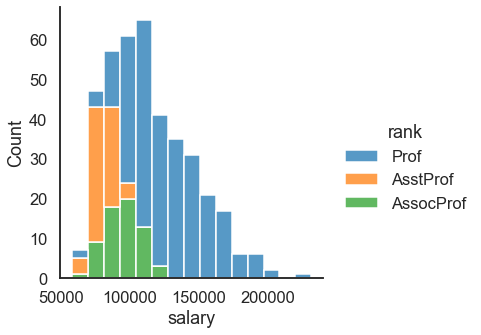

In [19]:
sns.displot(data=salary_data, x='salary', hue='rank', multiple='stack')

In [20]:
prof_salary = salary_data['salary'][salary_data['rank'] == 'Prof']
asstprof_salary = salary_data['salary'][salary_data['rank'] == 'AsstProf']
assocprof_salary = salary_data['salary'][salary_data['rank'] == 'AssocProf']

Test for normality.

Prof skew: 0.5900071212136428
AsstProf skew: 0.08297549121003074
AssocProf skew: -0.08589258223727936


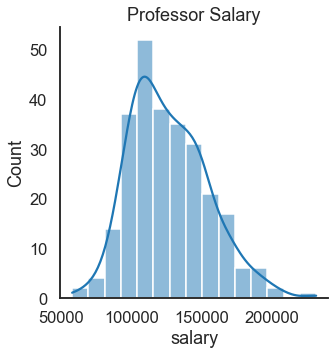

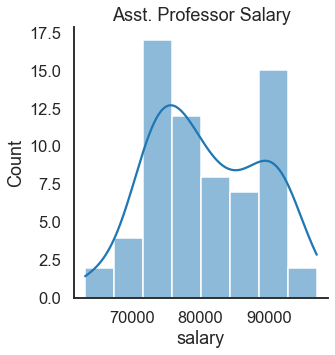

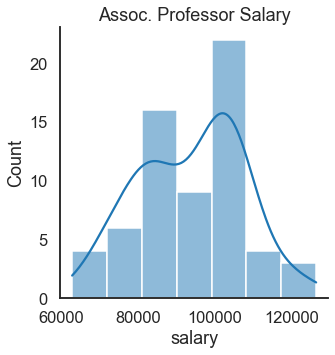

In [36]:
sns.displot(prof_salary, kde=True)
plt.title("Professor Salary")
sns.displot(asstprof_salary, kde=True)
plt.title("Asst. Professor Salary")
sns.displot(assocprof_salary, kde=True)
plt.title("Assoc. Professor Salary")

print(f"Prof skew: {prof_salary.skew()}")
print(f"AsstProf skew: {asstprof_salary.skew()}")
print(f"AssocProf skew: {assocprof_salary.skew()}")

Test for equal variance with Levene's test.

The F-test is robust to the homogeneity of variance assumption (the assumption that the variances of all groups is roughly equal), so even if the variances differ the test is still valid.

In [22]:
test_stat, p_value = stats.levene(prof_salary.values, asstprof_salary.values, assocprof_salary.values)
alpha = 0.05

if p_value > alpha:
  print("Retain H0 - variance is roughly equal")
else:
  print("Reject H0 - variance is not equal")

print(f"alpha: {alpha}")
print(f"p-value: {p_value}")
print(f"test stat: {test_stat}")

Reject H0 - variance is not equal
alpha: 0.05
p-value: 4.476856382324779e-16
test stat: 38.711118112709656


The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality.  If p-value is not less than 0.05 then we cannot reject null hypothesis that variance is the same.

## ANOVA Test

Perform ANOVA test.

In [23]:
stats.f_oneway(prof_salary, asstprof_salary, assocprof_salary)

F_onewayResult(statistic=128.2173938320361, pvalue=1.29304847087234e-43)

Once again, we find that we reject the null hypothesis because of the resulting p-value. Notice the F-statistic is far greater than 1, meaning there is a considerably significant difference between means.

Our conclusion in this case is that at least one of the means (professor, assistant professor, or associate professor) is significantly different from the others. More tests would have to be performed to determine which groups are different.

## Tukey's Range Test

Another test similar to ANOVA is Tukey's Range Test (also called "Tukey's HSD (honestly significantly different) test" as referenced in the code), which is essentially a good next step after running an ANOVA test that rejects the null hypothesis. This test compares mean of pair-wise groups based on the Student's distribution (similar to the t-distribution). The same assumptions about normal distribution and equal variance apply to this test.

In [24]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=salary_data['salary'], groups=salary_data['rank'], alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
AssocProf,AsstProf,-13100.4524,0.0047,-22819.1231,-3381.7818,True
AssocProf,Prof,32895.6715,0.001,25154.1777,40637.1653,True
AsstProf,Prof,45996.1239,0.001,38395.618,53596.6299,True


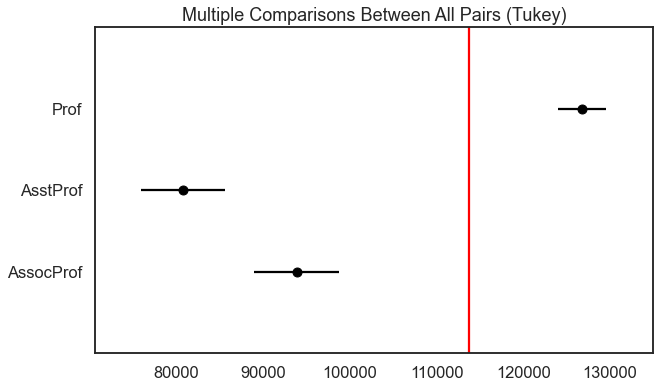

In [25]:
# Plot group means
tukey.plot_simultaneous()

# Add mean of entire dataset to plot
# ymin and ymax are required for vlines. The plot starts at y=-1 and 
# with 3 categories goes up to y=3.
plt.vlines(x=salary_data['salary'].mean(), ymin=-1, ymax=3, color='red')

# Regression Analysis

A similar form of statistical analysis that can be used a hypothesis test is regression analysis. Here we are determining if there is a relationship between two variables. If we choose a linear regression analysis, the simplest form of regression analysis, we are supposing that the relationship is linear. This yields a model of the form
$$
y = \beta_0 + \beta_1 x+ \epsilon
$$
where y is the dependent variable, $x$ is the independent variable, $\beta_0$ is the y-intercept, $\beta_1$ is the slope, and $\epsilon$ is the error between what the model predicts and what the true value is.

The linear regression model minimizes the sum of the squared distance between each data point to the line: $\sum (\hat{y} - y)^2$. This is often abbreviated as $SS_{total}$.

In [26]:
model = stats.linregress(x=salary_data['years_of_service'], y=salary_data['salary'])
model

LinregressResult(slope=779.569113694737, intercept=99974.65286632923, rvalue=0.3347446756998621, pvalue=7.528739019469755e-12, stderr=110.41693214331899, intercept_stderr=2416.6052625809575)

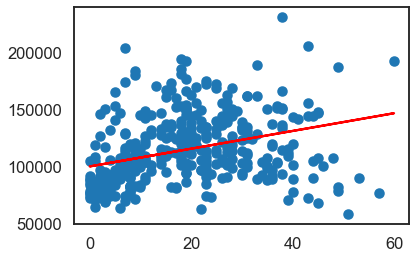

In [27]:
plt.scatter(x=salary_data['years_of_service'], y=salary_data['salary'])
plt.plot(salary_data['years_of_service'], salary_data['years_of_service']*model.slope+model.intercept, color='r')

The linear regression model can also be used as a hypothesis test to determine whether or not there is a relationship between two variables. We can even see that `stats.linregress` has return a p-value in addition to the slope and intercept. This p-value corresponds to a t-test with the null hypothesis that the slope of the line is 0.

Why do we care about the slope and not the intercept? The slope is actually interpretable. It represents how the dependent variable is proportionally influenced by the independent variable. That is, with $x$ number of years of service, we can generally expect an increase of $799/year in salary. If there were no relationship between salary and years of service, the slope should be 0 (a flat line across the plot).

The intercept on the other hand is generally not interpretable. We could say that this generally represents what a starting salary might be for a new PhD graduate, but in most cases there is not much meaning to the intercept.

Since the p-value is far below 0.05, we can confidently say that the null hypothesis is rejected and therefore there is a relationship between years of service and salary.

# More Information

A great overview of all the topics we've covered and more, check out the Crash Course Statistics playlist on YouTube: https://www.youtube.com/playlist?list=PL8dPuuaLjXtNM_Y-bUAhblSAdWRnmBUcr

StatQuest on linear regression: https://www.youtube.com/watch?v=nk2CQITm_eo